In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

데이터 불러오기 및 전처리


In [ ]:
# [1-1] 데이터프레임으로 불러오기
df = pd.read_csv('서울대기오염_2019.csv', encoding="utf-8")
# df.head()

# [1-2] 분석변수만 추출 및 컬럼명 변경: date, district, pm10, pm25
df = df[['날짜', '측정소명', '미세먼지', '초미세먼지']].copy()
df.columns = ['date', 'district', 'pm10', 'pm25']

# [1-3] 결측치 확인 및 제거(결측치와 이상치 두가지로 나눠서 보시고 이상치는 제거, 결측치는 제거 또는 다른 정규/표준화 적용 가능한지 판단 하세요.)
df.isnull().sum()
# - 결측치는 제거 또는 평균/중앙값 대체 등 정규화/표준화 가능성도 함께 고려하세요.
df = df.dropna(subset=['date', 'district'])
df['pm10'] = df['pm10'].fillna(df['pm10'].mean())
df['pm25'] = df['pm25'].fillna(df['pm25'].mean())

# - 이상치는 도메인 기준(직관적 판단 이며 통계적 기준(IQR, Z-score 등)은 고려하지 마세요)으로 판단해 제거 여부 결정합니다.
df = df[df['pm25'] <= df['pm10']]

# [1-4] 자료형 변환: 문자형 → 날짜형, 실수형 등
df = df[df['district'] != '평균']
df = df[df['date'] != '전체']

df['date'] = pd.to_datetime(df['date'])

df['pm10'] = df['pm10'].astype(float)
df['pm25'] = df['pm25'].astype(float)

# print(df.dtypes)
# df.isnull().sum()

파생변수 만들기

In [ ]:
# [2-1] month, day 파생변수 생성
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# [2-2] 계절(season) 변수 생성: month 기준으로 spring(3~5월)/summer(6~8월)/autumn(9~11월)/winter(12~2월)
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'

df['season'] = df['month'].apply(get_season)
# df.head()

,date,district,pm10,pm25,month,day,season
2,2019-12-31,강남구,22.0,14.0,12,31,winter
3,2019-12-31,강동구,27.0,19.0,12,31,winter
4,2019-12-31,강북구,31.0,17.0,12,31,winter
5,2019-12-31,강서구,29.0,16.0,12,31,winter
6,2019-12-31,관악구,36.0,18.0,12,31,winter


전처리 완료 데이터 확인 및 저장

In [105]:
# 최종 분석 대상 데이터 확인
df.head()
df.isnull().sum()
df.info()
df.describe()

# [3-2] 'card_output.csv'로 저장 (GitHub에 업로드 or 구글 드라이브 공유)
df.to_csv('card_output.csv', index=False, encoding='utf-8-sig')

<class 'pandas.core.frame.DataFrame'>
Index: 9078 entries, 2 to 9490
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      9078 non-null   datetime64[ns]
 1   district  9078 non-null   object        
 2   pm10      9078 non-null   float64       
 3   pm25      9078 non-null   float64       
 4   month     9078 non-null   int32         
 5   day       9078 non-null   int32         
 6   season    9078 non-null   object        
dtypes: datetime64[ns](1), float64(2), int32(2), object(2)
memory usage: 496.5+ KB


데이터 분석 단계

In [ ]:
# [4-1] 전체 데이터 기준 PM10 평균
pm10_mean = df['pm10'].mean()
print(f'연간 미세먼지 평균 농도 : {pm10_mean}')
# 분석 결과 : 연간 미세먼지 평균 농도는 대략 42㎍/m³ 이다

# [5-1] PM10 최댓값이 발생한 날짜, 구 출력
pm10_max = df.loc[df['pm10'].idxmax()]
print(f"날짜: {pm10_max['date'].date()} / 지역: {pm10_max['district']}")
# 분석 결과 : 1년 동안 가장 미세먼지 농도가 높았던 날과 지역은 2019년 3월 5일 강북구였고, 수치는 대략 228㎍/m³ 이다

# [6-1] 각 구별 평균 PM10 계산
pm10_group = df.groupby('district')['pm10'].mean().reset_index()
pm10_group.columns = ['district', 'avg_pm10']

# [6-2] 상위 5개 구 출력
pm10_top5 = pm10_group.sort_values(by='avg_pm10', ascending=False).head(5)
print(pm10_top5)
# 분석 결과 : 구 별로 미세먼지 농도를 분석해보았을떄 내림차순으로림차순으로 관악구가 가장 높았고 
# 그 다음으로 양천구, 마포구, 강서구, 강북구 순으로 높았다.

연간 미세먼지 평균 농도 : 41.890182999285585
날짜: 2019-03-05 / 지역: 강북구
   district   avg_pm10
4       관악구  48.015506
18      양천구  47.678762
12      마포구  46.817459
3       강서구  46.478071
2       강북구  44.950685


In [126]:
# [7-1] 계절별 평균 pm10, pm25 동시 출력
season_avg = df.groupby('season')[['pm10', 'pm25']].mean().reset_index()
season_avg.columns = ['season', 'avg_pm10', 'avg_pm25']

# [7-2] 오름차순 정렬
season_avg_sorted = season_avg.sort_values(by='avg_pm10')
print(season_avg_sorted)

# 분석 결과: 개절 중 봄, 겨울이 여름, 가을과 비교했을떄 비교적 미세먼지, 초미세먼지 농도가 높은 것을 보여주고 있다.

   season   avg_pm10   avg_pm25
2  summer  26.618760  18.146183
0  autumn  32.049643  16.447355
1  spring  54.244328  31.629145
3  winter  54.665733  33.620860


In [ ]:
# [8-1] pm10 값을 기준으로 등급 분류 (good/normal/bad/worse)
def classify_pm10(pm10):
    if pm10 <= 30:
        return 'good'
    elif pm10 <= 80:
        return 'normal'
    elif pm10 <= 150:
        return 'bad'
    else:
        return 'worse'

df['pm_grade'] = df['pm10'].apply(classify_pm10)
df.head()

# [8-2] 전체 데이터 기준 등급별 빈도, 비율 계산 (컬럼: pm_grade, n, pct)
ratio = df['pm_grade'].value_counts().reset_index()
ratio.columns = ['pm_grade', 'n']
ratio['pct'] = round(ratio['n'] / ratio['n'].sum() * 100, 2)

print(ratio)

# 분석 결과 : 90% 이상의 날은 미세먼지가 정상 이상이다

  pm_grade     n    pct
0   normal  5021  55.31
1     good  3373  37.16
2      bad   603   6.64
3    worse    81   0.89


In [136]:
# [9-1] 구별 등급 분포 중 'good' 빈도와 전체 대비 비율 계산
good_counts = df[df['pm_grade'] == 'good'].groupby('district').size().reset_index(name='n')

total_counts = df.groupby('district').size().reset_index(name='total')
good_pct = pd.merge(good_counts, total_counts, on='district')
good_pct['pct'] = round(good_pct['n'] / good_pct['total'] * 100, 2)

# [9-2] 비율(pct) 기준 내림차순 정렬 후 상위 5개 구만 출력 (컬럼: district, n, pct)
top5_good = good_pct.sort_values(by='pct', ascending=False).head(5)
print(top5_good[['district', 'n', 'pct']])

# 분석 결과 : 구 별로 미세먼지 good등급 빈도를 분석해보았을떄 내림차순으로 용산구가 가장 높았고 미세먼지
#  good 빈도가 높았고 그 다음으로 종구, 종로구, 도봉구, 금천구 순으로 높다다

   district    n    pct
20      용산구  192  53.33
23       중구  169  46.30
22      종로구  163  44.66
9       도봉구  162  44.38
7       금천구  160  44.08


시각화

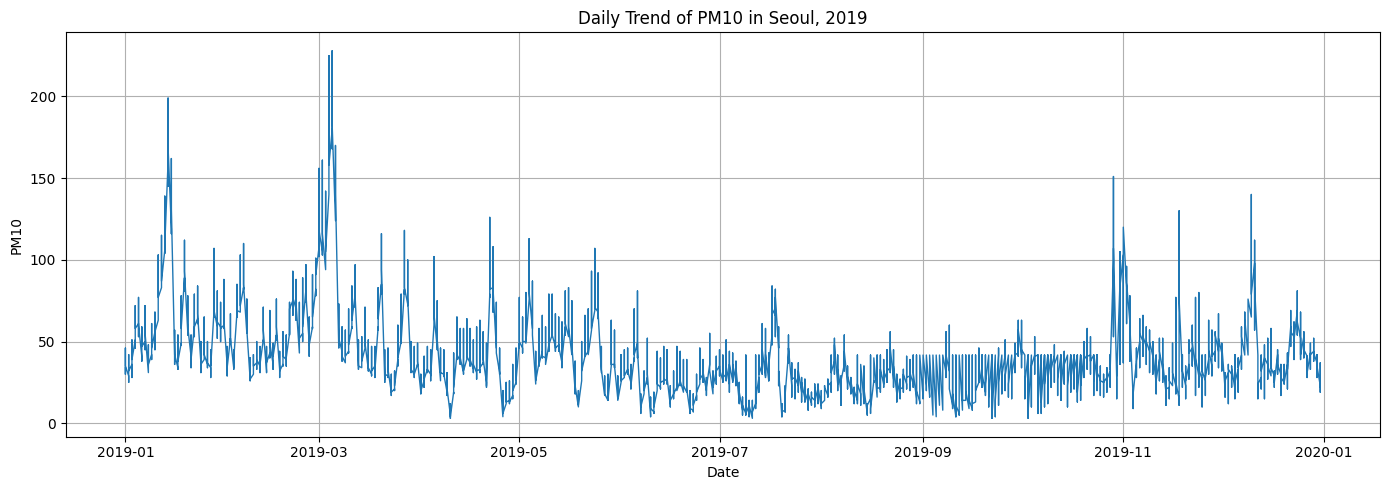

In [ ]:
# [10-1] x축: date, y축: pm10 (선그래프)
# [10-2] 제목: 'Daily Trend of PM10 in Seoul, 2019'
plt.figure(figsize=(14, 5))
plt.plot(df['date'], df['pm10'], linewidth=1)
plt.title('Daily Trend of PM10 in Seoul, 2019')
plt.xlabel('Date')
plt.ylabel('PM10')
plt.grid(True)
plt.tight_layout()
plt.show()

# 분석 결과 : 연중 1월에서 3월이 가장 미세먼지 농도가 높다는 것을 알 수 있고 그 이후에 점점 내려가다
# 다시 11월부터 미세먼지 농도가 올라가는 것을 알 수 있다다

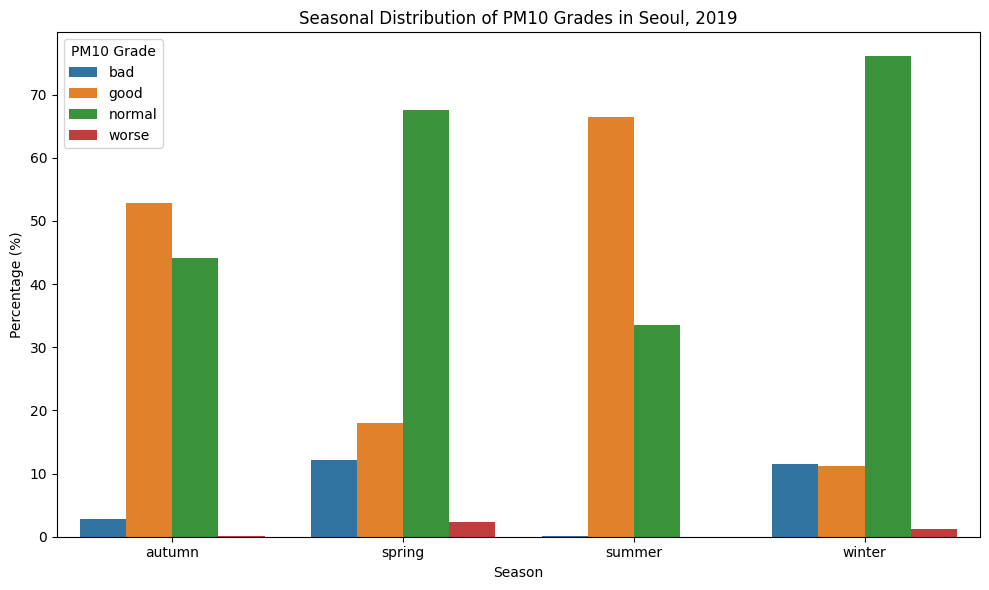

In [143]:
# 시즌별 등급 분포
season_grade = (
    df.groupby(['season', 'pm_grade'])
    .size()
    .reset_index(name='n')
)

# 비율
season_total = season_grade.groupby('season')['n'].transform('sum')
season_grade['pct'] = round(season_grade['n'] / season_total * 100, 2)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=season_grade, x='season', y='pct', hue='pm_grade')
plt.title('Seasonal Distribution of PM10 Grades in Seoul, 2019')
plt.ylabel('Percentage (%)')
plt.xlabel('Season')
plt.legend(title='PM10 Grade')
plt.tight_layout()
plt.show()

# 분석 결과 : 가을에는 미세먼지 농도가 good, normal 비율이 높고
# 봄에는 normal 이 다른 등급들의 비해 많이 높고
# 여름에는 bad, worse 비율이 거의 없다고 봐도 무방하고, 겨울에는 normal이 앞도적으로 높다